In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [2]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Set CUDA_LAUNCH_BLOCKING environment variable
!export CUDA_LAUNCH_BLOCKING=1

In [5]:
# Set your custom dataset path
data_dir = "gdrive/MyDrive/Colab Notebooks/ucb_capstone_asd_detection/data"

In [6]:
# Set the number of classes in your dataset
num_classes = 4

# Set batch size, number of epochs, and learning rate
batch_size = 16
num_epochs = 20
learning_rate = 1e-4

In [7]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir+'/train', transforms.ToTensor())
for image in images:
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

(tensor([0.0013, 0.0014, 0.0011]), tensor([0.0100, 0.0114, 0.0106]))

In [8]:
stats = ((average / len(images)).tolist(), (standard_dev / len(images)).tolist())
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(*stats,inplace=True)
                                    ])

In [11]:
# Load your custom dataset
image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

In [12]:
# Split the dataset into train and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

In [13]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [17]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

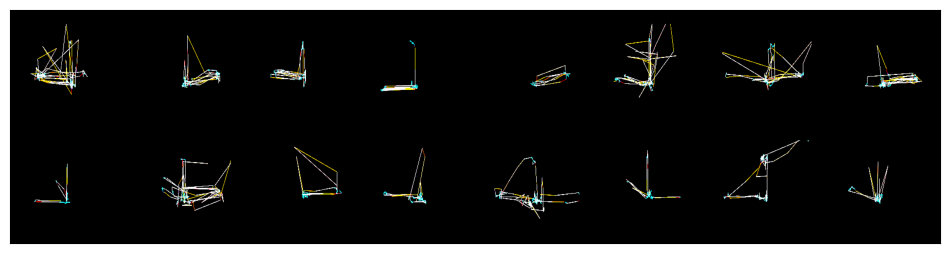

In [20]:
show_batch(train_loader);

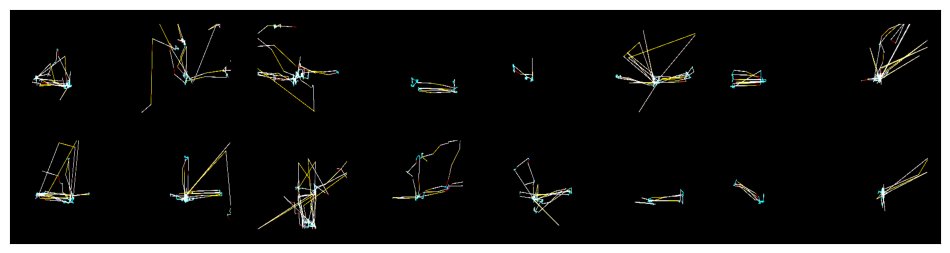

In [21]:
show_batch(val_loader);

In [41]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

In [42]:
# Extract features (everything except the classification layer)
class ResNetFeatures(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatures, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        return x

# Create a custom classification head
class CustomClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomClassifier, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Create the feature extractor
feature_extractor = ResNetFeatures(model)

# Get the number of input features for the custom classifier
num_features = model.fc.in_features

# Create the custom classification head
custom_classifier = CustomClassifier(num_features, num_classes)

# Combine the feature extractor and the custom classifier
model = nn.Sequential(feature_extractor, custom_classifier)


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): ResNetFeatures(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
     

In [49]:
# Training loop
train_losses, val_losses, accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Training steps
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate training loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/20: Train Loss: 0.3485, Val Loss: 0.3601, Val Acc: 89.09%
Epoch 2/20: Train Loss: 0.2462, Val Loss: 0.3816, Val Acc: 89.09%
Epoch 3/20: Train Loss: 0.1554, Val Loss: 0.3671, Val Acc: 89.09%
Epoch 4/20: Train Loss: 0.0878, Val Loss: 0.4594, Val Acc: 89.09%
Epoch 5/20: Train Loss: 0.0341, Val Loss: 0.4637, Val Acc: 88.18%
Epoch 6/20: Train Loss: 0.0256, Val Loss: 0.4653, Val Acc: 89.09%
Epoch 7/20: Train Loss: 0.0163, Val Loss: 0.5907, Val Acc: 89.09%
Epoch 8/20: Train Loss: 0.0134, Val Loss: 0.5278, Val Acc: 89.09%
Epoch 9/20: Train Loss: 0.0099, Val Loss: 0.5318, Val Acc: 88.18%
Epoch 10/20: Train Loss: 0.0061, Val Loss: 0.4935, Val Acc: 88.18%
Epoch 11/20: Train Loss: 0.0064, Val Loss: 0.5417, Val Acc: 88.18%
Epoch 12/20: Train Loss: 0.0050, Val Loss: 0.5502, Val Acc: 88.18%
Epoch 13/20: Train Loss: 0.0042, Val Loss: 0.5515, Val Acc: 88.18%
Epoch 14/20: Train Loss: 0.0037, Val Loss: 0.5442, Val Acc: 88.18%
Epoch 15/20: Train Loss: 0.0053, Val Loss: 0.6197, Val Acc: 88.18%
Epoc

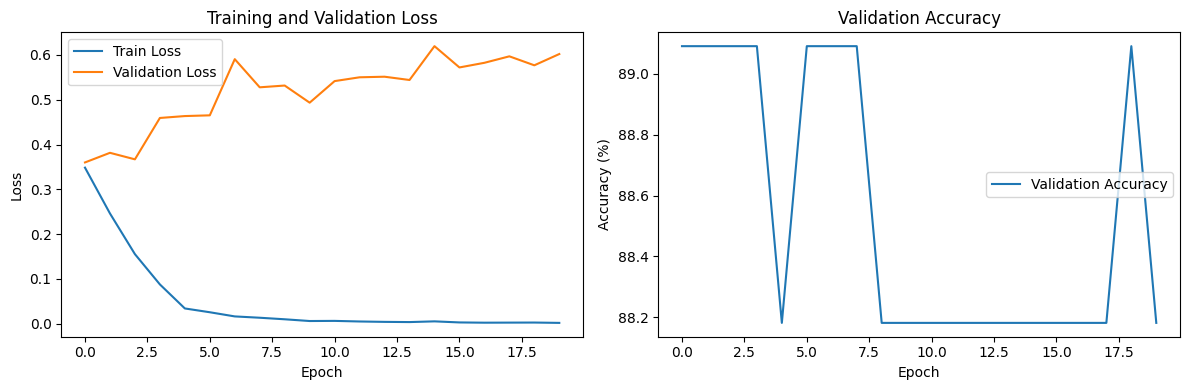

In [50]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

In [51]:
torch.save(model.state_dict(), 'custom_resnet50.pth')